In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from strm2stl import dem2stl
from PIL import Image 

In [2]:
def ProcessDEMList(Root, Coor,idxs):
    for i in idxs:
        Row = Coor.iloc[i]
        DEM = dem2stl.get_section(Root, (Row["GridX1"], Row["GridY1"]), (Row["GridX2"]+1,Row["GridY2"]+1))
        DEM = np.maximum(DEM,-1)        
        
        DEM = dem2stl.crop_region(DEM, (Row["X1"], Row["Y1"]), (Row["X2"],Row["Y2"]),0)
        DEM = resize(DEM, np.round(np.array(DEM.shape) * 1000 / np.amax(DEM.shape)))
        plt.imshow(DEM)

def ShowDem(Root,Coor,idxs):
    for i in idxs:
        DEM = GetDem(Root,Coor,i)
        DEM = np.maximum(DEM,-1)  
        DEM = resize(DEM, np.round(np.array(DEM.shape) * 2000 / np.amax(DEM.shape)))
        
        fig=plt.figure()
        ax=fig.add_axes([0.1,0.1,0.8,0.8])
        plt.imshow(DEM)

def GetDem(Root,Coor,idx): 
    Row = Coor.iloc[idx]
    DEM = dem2stl.get_section(Root, (Row["GridX1"], Row["GridY1"]), (Row["GridX2"]+1,Row["GridY2"]+1))               
    DEM = dem2stl.crop_region(DEM, (Row["X1"], Row["Y1"]), (Row["X2"],Row["Y2"]),0)
    return DEM

#def GeoCoor2TileNum(Lat=0,Long=0):

    #TileX1 = 36*(Long / 90)+12
    #TileX2 = 36*(Long / 90)
    
    #return tile_coordinates

def TileNum2GeoCoor(X=0,Y=0):

    Long = 180 * (X -36)/36
    Lat = 90 * (Y -12)/12

    GeoCoor = {"Lat":Lat, "Long":Long}

    return GeoCoor     


D:\OneDrive - Drexel University\Documents\CGIARdata\srtm_22_04.tif


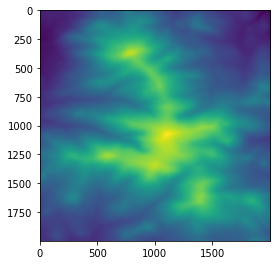

In [3]:
Root = "D:\OneDrive - Drexel University\Documents\CGIARdata"
#Root = r'C:\Users\Edgar\Desktop\Data'

bExport = 0

Coor = pd.read_excel('CoOrLists.xls')
#ProcessDEMList(Root, Coor, [15])
ShowDem(Root, Coor,[10])



In [4]:
import stl_tools
import osmnx as ox
place_name = "Pennsylvania,USA"
graph = ox.graph_from_place(place_name)
fig, ax = ox.plot_graph(graph)
plt.tight_layout()


ModuleNotFoundError: No module named 'stl_tools'

In [ ]:
from PIL import Image 
mapIM = Image.open("MapList.PNG")
plt.imshow(mapIM)
plt.show()
for index, row in Coor.iterrows():
    TileNum2GeoCoor(Row["X1"], Row["Y1"])

plt.imshow(DEM)


In [ ]:
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
# create new figure, axes instances.
fig=plt.figure()
ax=fig.add_axes([0.1,0.1,0.8,0.8])
# setup mercator map projection.
m = Basemap(llcrnrlon=-100.,llcrnrlat=20.,urcrnrlon=20.,urcrnrlat=60.,\
            rsphere=(6378137.00,6356752.3142),\
            resolution='l',projection='merc',\
            lat_0=40.,lon_0=-20.,lat_ts=20.)
# nylat, nylon are lat/lon of New York
nylat = 40.78; nylon = -73.98
# lonlat, lonlon are lat/lon of London.
lonlat = 51.53; lonlon = 0.08
# draw great circle route between NY and London
m.drawgreatcircle(nylon,nylat,lonlon,lonlat,linewidth=2,color='b')
m.drawcoastlines()
m.fillcontinents()
# draw parallels
m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
# draw meridians
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])
ax.set_title('Great Circle from New York to London')
plt.show()

In [9]:
from PIL import Image 
from scipy.ndimage import gaussian_filter
from skimage import filters, morphology, color as skicolor


In [26]:
def SegTerrain(mapIM_0):
    ## Segment Images
    npMap = np.array(mapIM_0)[...,:3]/255
    #npMag = np.linalg.norm(npMap,axis=2)

    vectors = np.array([[.3,1,0],[1,0,0],[0,0,1],[0,0,0]])
                       #,[0,0,0],[1,1,1],[.5,.5,.5]])
    #vectMag = np.array([np.linalg.norm(vectors,axis=1)]).T

    npDoT = np.full(npMap.shape[0:2] + (vectors.shape[0],), -1,"f4")

    for i in range(vectors.shape[0]):

        #Get Distance to color
        npTemp = np.linalg.norm(npMap - [[vectors[i]]], axis=2)
        npTemp = -npTemp

        npTemp[npTemp<npTemp.mean()] = npTemp.mean() 
        # Highpass filtering to get lines 
        npTemp = npTemp - gaussian_filter(npTemp, sigma=5)
        npTemp[npTemp<0] = 0
        
        #Thresholding 
        topDev = np.median(npTemp)+3*npTemp.std()
        botDev = np.median(npTemp)-3*npTemp.std()
        
        #npTemp[npTemp > topDev] = topDev
        #npTemp[npTemp < botDev] = botDev
        
        npTemp = npTemp.clip(botDev,topDev)
        
        npTemp = (npTemp - npTemp.min()) / (npTemp.max() - npTemp.min())

        npDoT[:,:,i] = npTemp
        #npDoT[:,:,i] = npMap.dot(vectors[i]) / (npMag * vectMag[i])              

    segIM = np.zeros((np.array(npMap).shape[0:2]))-1
    for i in range(vectors.shape[0]):
        bSeg = npDoT[...,i]>0.75
        bSeg = morphology.remove_small_objects(bSeg,20)
        segIM[bSeg] = i+1
        
    return segIM,npDoT



    
    

In [27]:
mapIM_0 = Image.open("../Satelite/Killington _43.6107026_ -72.796019,4995_terrian.JPG")
#mapIM_0 = Image.open("../Satelite/Killington _43.6107026_ -72.796019,4995.JPG")

segIM,npDoT = SegTerrain(mapIM_0)

X1,X2,Y1,Y2 = 0,1000,400,1600

crop_rectangle = (Y1, X1, Y2, X2)

labIM = skicolor.label2rgb(segIM)
if 0:
    f, axarr = plt.subplots(1,2,figsize=(40, 20))

    axarr[0].imshow(mapIM_0.crop(crop_rectangle))
    axarr[1].imshow(labIM[X1:X2,Y1:Y2])
else:
    f, ax = plt.subplots(2,3,figsize=(20, 10))
    ax[0,0].imshow(mapIM_0.crop(crop_rectangle))
    ax[0,1].imshow(labIM[X1:X2,Y1:Y2])
    ax[0,2].imshow(npDoT[X1:X2,Y1:Y2,0])
    ax[1,0].imshow(npDoT[X1:X2,Y1:Y2,1])
    ax[1,1].imshow(npDoT[X1:X2,Y1:Y2,2])
    ax[1,2].imshow(npDoT[X1:X2,Y1:Y2,3])
plt.tight_layout()

In [63]:
from scipy import ndimage

Sat_IM = Image.open("../Satelite/Killington_Sat.jpg")

seg_Sat = np.array(Sat_IM)[...,:3]/255
seg_Sat = -np.linalg.norm(seg_Sat, axis=2)

topDev = np.mean(seg_Sat)+3*seg_Sat.std()
botDev = np.mean(seg_Sat)-3*seg_Sat.std()
#seg_Sat = seg_Sat.clip(botDev,topDev)

#seg_Sat  = ndimage.sobel(seg_Sat)

f, ax = plt.subplots(1,3,figsize=(40, 20))
ax[0].imshow(Sat_IM,cmap = 'jet');
ax[1].imshow(seg_Sat,cmap = 'jet');
ax[2].hist(seg_Sat.ravel(), bins = 256)

(array([5.0000e+00, 2.6000e+01, 7.2000e+01, 1.6700e+02, 1.2500e+02,
        1.7900e+02, 2.3700e+02, 2.1100e+02, 2.4600e+02, 2.4100e+02,
        2.2200e+02, 1.9800e+02, 2.3100e+02, 2.1900e+02, 2.3000e+02,
        2.2300e+02, 2.1300e+02, 2.2300e+02, 2.1800e+02, 2.3300e+02,
        2.2000e+02, 2.2500e+02, 2.2400e+02, 2.5100e+02, 2.6300e+02,
        2.5300e+02, 2.6900e+02, 2.4800e+02, 2.6800e+02, 2.6500e+02,
        2.8100e+02, 2.3100e+02, 2.6000e+02, 2.6100e+02, 2.5700e+02,
        2.2300e+02, 2.6100e+02, 2.2900e+02, 2.0100e+02, 2.3400e+02,
        2.2200e+02, 1.9800e+02, 2.3100e+02, 2.4800e+02, 2.0000e+02,
        2.3200e+02, 1.9800e+02, 2.2700e+02, 2.1300e+02, 2.0500e+02,
        2.0300e+02, 2.1600e+02, 1.8400e+02, 1.7200e+02, 1.9800e+02,
        1.9500e+02, 2.0800e+02, 1.8400e+02, 1.9900e+02, 1.8200e+02,
        1.8800e+02, 1.7500e+02, 1.9600e+02, 2.1600e+02, 1.8800e+02,
        2.0400e+02, 1.7800e+02, 1.8000e+02, 1.7600e+02, 1.9900e+02,
        2.0300e+02, 1.9300e+02, 1.8600e+02, 1.94

In [57]:
from skimage.transform import ProjectiveTransform, SimilarityTransform
from skimage.measure import ransac
from skimage.transform import warp

mapIM_0 = Image.open("../Satelite/Killington _43.6107026_ -72.796019,4995_terrian.JPG")
#mapIM_0 = Image.open("../Satelite/Killington _43.6107026_ -72.796019,4995.JPG")

bExport = 0

Coor = pd.read_excel('CoOrLists.xls')
Coor.at[10,["X1","X2","Y1","Y2"]] = [1610,1720,2580,2690]

DEM = GetDem(Root, Coor,10)
DEM = resize(DEM, np.round(np.array(DEM.shape) * 2000 / np.amax(DEM.shape)))

segIM = SegTerrain(mapIM_0)[0]
## Add Annotations

#segIM = resize(segIM, DEM.shape)

demPts = np.array([[660,1190],[680,930],[580,730],[1010,1110]])
satPts = np.array([[425,640],[434,327],[365,80],[750,560]])

model_robust, inliers = ransac((satPts,demPts), SimilarityTransform,
                               min_samples=10, residual_threshold=1, 
                               max_trials=300)

segIM_reg = warp(np.array(segIM), model_robust.inverse, preserve_range=True,
               output_shape=DEM.shape, cval=-1)


DEM[segIM_reg>-1] = 0
#DEM[segIM_reg>-1] = DEM[segIM_reg>-1]-0.005

f, ax = plt.subplots(1,2,figsize=(40, 20))
ax[0].imshow(DEM,cmap = 'jet');
ax[0].plot(demPts[:,0],demPts[:,1])
ax[1].imshow(mapIM_0);
ax[1].plot(satPts[:,0],satPts[:,1])

f, ax = plt.subplots(1,1,figsize=(40, 20))
ax.imshow(DEM,cmap = 'jet');

D:\OneDrive - Drexel University\Documents\CGIARdata\srtm_22_04.tif


In [51]:
%matplotlib qt

In [ ]:
from skimage.feature import ORB, match_descriptors, plot_matches
from skimage.transform import ProjectiveTransform, SimilarityTransform
from skimage.measure import ransac

image1 = Image.open("../Satelite/Killington _43.6107026_ -72.796019,4995_terrian.JPG")
image2 = Image.open("../Satelite/Killington _43.6107026_ -72.796019,4995.JPG")

image1 = np.array(SegTerrain(image1)>-1)
image2 = np.array(SegTerrain(image2)>-1)

orb = ORB(n_keypoints=500, fast_threshold=0.05)
orb.detect_and_extract(image1)
keypoints1 = orb.keypoints
descriptors1 = orb.descriptors

orb.detect_and_extract(image2)
keypoints2 = orb.keypoints
descriptors2 = orb.descriptors

matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)

src = keypoints2[matches12[:, 1]][:, ::-1]
dst = keypoints1[matches12[:, 0]][:, ::-1]

model_robust, inliers = ransac((src, dst), SimilarityTransform,
                               min_samples=10, residual_threshold=1, 
                               max_trials=300)

if 0:
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    plot_matches(ax, image1, image2, keypoints1, keypoints2, matches12[inliers])
    ax.axis('off')
    plt.show()
else:    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    plot_matches(ax, image1, image2, keypoints1, keypoints2, matches12, only_matches=True)
    plt.axis('off')
    plt.show()

In [55]:

segIM.shape


(1105, 1798)

In [ ]:
from skimage.feature import ORB, match_descriptors, plot_matches
from skimage.transform import ProjectiveTransform, SimilarityTransform
from skimage.measure import ransac
from skimage.transform import warp


image1 = Image.open("../Satelite/Killington _43.6107026_ -72.796019,4995_terrian.JPG")

Dem = GetDem(Root, Coor,10)

if 0:
    
    %matplotlib qt
    fig, axarr = plt.subplots(1,1,figsize=(20, 20))
    ax=fig.add_axes([0.1,0.1,0.8,0.8])
    plt.imshow(image1)
    
    ShowDem(Root, Coor,[10])
    

In [ ]:
demPts = np.array([[660,1190],[680,930],[580,730],[1010,1110]])
satPts = np.array([[425,465],[434,327],[365,80],[750,680]])


model_robust, inliers = ransac((demPts, satPts), SimilarityTransform,
                               min_samples=10, residual_threshold=1, 
                               max_trials=300)

image2 = warp(np.array(image1), model_robust.inverse, preserve_range=True,
               output_shape=Dem.shape, cval=-1)

%matplotlib qt
fig, axarr = plt.subplots(1,1,figsize=(20, 20))
ax=fig.add_axes([0.1,0.1,0.8,0.8])
plt.imshow(image1)


DEM[segIM>-1] = 0
#DEM[segIM>-1] = DEM[segIM>-1]+0.005


f, ax = plt.subplots(1,1,figsize=(40, 20))
ax.imshow(DEM);